## Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read base dataset

In [13]:
data= pd.read_csv('/Users/alexnaderspude/Desktop/Desktop/TUM MMT/DTU Kurs/Group Project/Trips_2018.csv')

### Basic information

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17545760 entries, 0 to 17545759
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tripduration             int64  
 1   starttime                object 
 2   stoptime                 object 
 3   start_station_id         float64
 4   start_station_latitude   float64
 5   start_station_longitude  float64
 6   end_station_id           float64
 7   end_station_latitude     float64
 8   end_station_longitude    float64
 9   bikeid                   int64  
 10  usertype                 object 
 11  birth_year               int64  
 12  gender                   int64  
 13  pickup_hour              int64  
 14  pickup_day               object 
 15  dropoff_hour             int64  
 16  dropoff_day              object 
dtypes: float64(6), int64(6), object(5)
memory usage: 2.2+ GB


In [15]:
data.describe()

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,gender,pickup_hour,dropoff_hour
count,1.754576e+07,1.754576e+07,1.754576e+07,1.754576e+07,1.754576e+07,1.754576e+07,1.754576e+07,1.754576e+07,1.754576e+07,1.754576e+07,1.754576e+07,1.754576e+07
mean,9.883411e+02,1.589273e+03,4.073733e+01,-7.398261e+01,1.580821e+03,4.073700e+01,-7.398283e+01,2.656028e+04,1.978991e+03,1.148621e+00,1.389121e+01,1.404865e+01
std,1.889178e+04,1.439428e+03,3.055744e-02,1.907803e-02,1.438499e+03,3.033265e-02,1.914617e-02,6.222635e+03,1.192900e+01,5.438034e-01,4.851942e+00,4.895536e+00
min,6.100000e+01,7.200000e+01,4.064654e+01,-7.402535e+01,7.200000e+01,4.064654e+01,-7.408364e+01,1.452900e+04,1.885000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.580000e+02,3.800000e+02,4.071755e+01,-7.399521e+01,3.800000e+02,4.071755e+01,-7.399595e+01,2.029300e+04,1.969000e+03,1.000000e+00,1.000000e+01,1.000000e+01
50%,6.050000e+02,5.050000e+02,4.073818e+01,-7.398565e+01,5.050000e+02,4.073756e+01,-7.398602e+01,2.826900e+04,1.981000e+03,1.000000e+00,1.500000e+01,1.500000e+01
75%,1.060000e+03,3.249000e+03,4.075763e+01,-7.397283e+01,3.249000e+03,4.075725e+01,-7.397344e+01,3.185000e+04,1.989000e+03,1.000000e+00,1.800000e+01,1.800000e+01
max,1.951005e+07,3.721000e+03,4.081439e+01,-7.390774e+01,3.721000e+03,4.081439e+01,-7.390774e+01,3.583100e+04,2.002000e+03,2.000000e+00,2.300000e+01,2.300000e+01


In [16]:
data.isnull().sum()

tripduration               0
starttime                  0
stoptime                   0
start_station_id           0
start_station_latitude     0
start_station_longitude    0
end_station_id             0
end_station_latitude       0
end_station_longitude      0
bikeid                     0
usertype                   0
birth_year                 0
gender                     0
pickup_hour                0
pickup_day                 0
dropoff_hour               0
dropoff_day                0
dtype: int64

### Convert data types

In [17]:
date_columns = ["starttime", "stoptime"]
categorical_columns = ["gender", "usertype", "start_station_id", "end_station_id"]
data[date_columns] = data[date_columns].apply(pd.to_datetime)
data[categorical_columns] = data[categorical_columns].apply(lambda x: x.astype('category'))

### Drop unnecesary column

In [18]:
data = data.drop(columns=['Unnamed: 0'])

KeyError: "['Unnamed: 0'] not found in axis"

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17545760 entries, 0 to 17545759
Data columns (total 17 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   tripduration             int64         
 1   starttime                datetime64[ns]
 2   stoptime                 datetime64[ns]
 3   start_station_id         category      
 4   start_station_latitude   float64       
 5   start_station_longitude  float64       
 6   end_station_id           category      
 7   end_station_latitude     float64       
 8   end_station_longitude    float64       
 9   bikeid                   int64         
 10  usertype                 category      
 11  birth_year               int64         
 12  gender                   category      
 13  pickup_hour              int64         
 14  pickup_day               object        
 15  dropoff_hour             int64         
 16  dropoff_day              object        
dtypes: category(4), datetime6

In [20]:
data.head()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,pickup_hour,pickup_day,dropoff_hour,dropoff_day
0,196,2018-01-01 00:01:50.650,2018-01-01 00:05:07.438,315.0,40.703554,-74.006702,259.0,40.701221,-74.012342,18534,Subscriber,1997,1,0,2018-01-01,0,2018-01-01
1,207,2018-01-01 00:02:43.918,2018-01-01 00:06:11.383,3224.0,40.739974,-74.005139,470.0,40.743453,-74.000040,19651,Subscriber,1978,1,0,2018-01-01,0,2018-01-01
2,613,2018-01-01 00:03:15.116,2018-01-01 00:13:28.480,386.0,40.714948,-74.002345,2008.0,40.705693,-74.016777,21678,Subscriber,1982,1,0,2018-01-01,0,2018-01-01
3,375,2018-01-01 00:06:43.709,2018-01-01 00:12:59.450,466.0,40.743954,-73.991449,325.0,40.736245,-73.984738,29822,Subscriber,1982,1,0,2018-01-01,0,2018-01-01
4,402,2018-01-01 00:06:56.924,2018-01-01 00:13:39.792,438.0,40.727791,-73.985649,380.0,40.734011,-74.002939,30722,Subscriber,1989,1,0,2018-01-01,0,2018-01-01


In [21]:
data = data.sort_values(by='starttime').reset_index(drop=True)

### Add date information

In [22]:
data["pickup_hour"] = data["starttime"].dt.hour
data["pickup_day"] = data["starttime"].dt.date
data["dropoff_hour"] = data["stoptime"].dt.hour
data["dropoff_day"] = data["stoptime"].dt.date

In [23]:
display(data.head())

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,pickup_hour,pickup_day,dropoff_hour,dropoff_day
0,196,2018-01-01 00:01:50.650,2018-01-01 00:05:07.438,315.0,40.703554,-74.006702,259.0,40.701221,-74.012342,18534,Subscriber,1997,1,0,2018-01-01,0,2018-01-01
1,207,2018-01-01 00:02:43.918,2018-01-01 00:06:11.383,3224.0,40.739974,-74.005139,470.0,40.743453,-74.000040,19651,Subscriber,1978,1,0,2018-01-01,0,2018-01-01
2,613,2018-01-01 00:03:15.116,2018-01-01 00:13:28.480,386.0,40.714948,-74.002345,2008.0,40.705693,-74.016777,21678,Subscriber,1982,1,0,2018-01-01,0,2018-01-01
3,375,2018-01-01 00:06:43.709,2018-01-01 00:12:59.450,466.0,40.743954,-73.991449,325.0,40.736245,-73.984738,29822,Subscriber,1982,1,0,2018-01-01,0,2018-01-01
4,402,2018-01-01 00:06:56.924,2018-01-01 00:13:39.792,438.0,40.727791,-73.985649,380.0,40.734011,-74.002939,30722,Subscriber,1989,1,0,2018-01-01,0,2018-01-01


### Extracting all distinct stations and cleaning

In [24]:
# extract distinct stations
stations_start = data[['start_station_id', 'start_station_latitude', 'start_station_longitude']].drop_duplicates().rename(columns={
    'start_station_id': 'station_id',
    'start_station_latitude': 'station_latitude',
    'start_station_longitude': 'station_longitude'
})

stations_end = data[['end_station_id', 'end_station_latitude', 'end_station_longitude']].drop_duplicates().rename(columns={
    'end_station_id': 'station_id',
    'end_station_latitude': 'station_latitude',
    'end_station_longitude': 'station_longitude'
})

stations = pd.concat([stations_start, stations_end]).drop_duplicates().reset_index(drop=True)

start_stations_set = set(stations_start['station_id'])
end_stations_set = set(stations_end['station_id'])

def categorize_station(station_id):
    in_start = station_id in start_stations_set
    in_end = station_id in end_stations_set
    
    if in_start and in_end:
        return 'both'
    elif in_start:
        return 'start'
    elif in_end:
        return 'end'
    else:
        return 'No station id'  # if station doesn't appear in either

# Add category column to stations DataFrame
stations['category'] = stations['station_id'].apply(categorize_station)


stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849 entries, 0 to 848
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         849 non-null    float64
 1   station_latitude   849 non-null    float64
 2   station_longitude  849 non-null    float64
 3   category           849 non-null    object 
dtypes: float64(3), object(1)
memory usage: 26.7+ KB


In [25]:
stations.describe()

,station_id,station_latitude,station_longitude
count,849.000000,849.000000,849.000000
mean,2367.020024,40.732443,-73.974450
std,1422.879904,0.039678,0.027383
min,72.000000,40.646538,-74.083639
25%,466.000000,40.699773,-73.992663
50%,3184.000000,40.730207,-73.976289
75%,3468.000000,40.763414,-73.953990
max,3721.000000,40.814394,-73.907744


In [26]:
outlier_stations = stations[stations['station_latitude'] >= 41]
outlier_stations.info()
outlier_stations.head()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         0 non-null      float64
 1   station_latitude   0 non-null      float64
 2   station_longitude  0 non-null      float64
 3   category           0 non-null      object 
dtypes: float64(3), object(1)
memory usage: 0.0+ bytes


,station_id,station_latitude,station_longitude,category


In [27]:
# remove outlier based on latitude
stations = stations[stations['station_latitude'] < 41]
stations_start = stations_start[stations_start['station_latitude'] < 41]
stations_end = stations_end[stations_end['station_latitude'] < 41]
stations.describe()


,station_id,station_latitude,station_longitude
count,849.000000,849.000000,849.000000
mean,2367.020024,40.732443,-73.974450
std,1422.879904,0.039678,0.027383
min,72.000000,40.646538,-74.083639
25%,466.000000,40.699773,-73.992663
50%,3184.000000,40.730207,-73.976289
75%,3468.000000,40.763414,-73.953990
max,3721.000000,40.814394,-73.907744


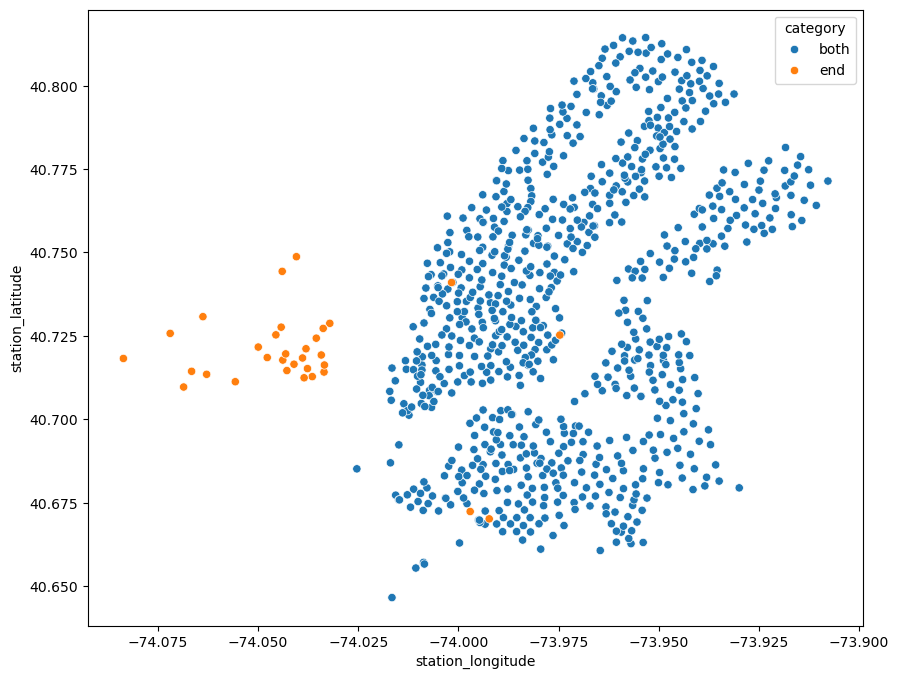

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=stations, x='station_longitude', y='station_latitude', hue='category')
plt.show()

The orange category seems suspicious, they are categorized a s none, because they do not have a station_id, and they have a very regular pattern

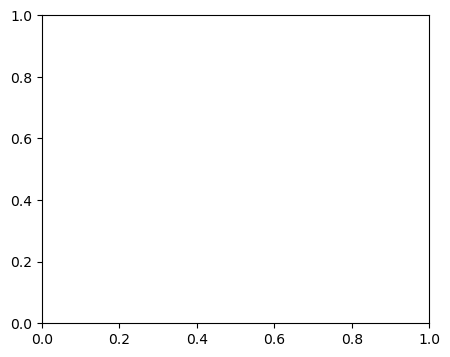

In [29]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(data=stations[stations['category'] == 'No station id'], x='station_longitude', y='station_latitude', hue='category')
plt.show()

In [30]:
stations = stations[stations['category'] != 'No station id']

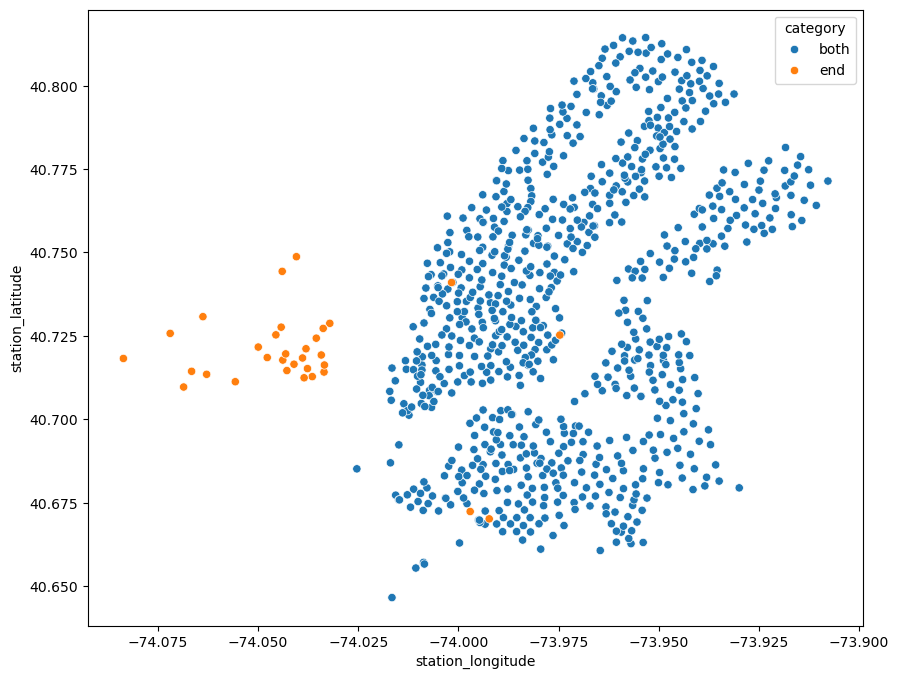

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=stations, x='station_longitude', y='station_latitude', hue='category')
plt.show()

In [32]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849 entries, 0 to 848
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         849 non-null    float64
 1   station_latitude   849 non-null    float64
 2   station_longitude  849 non-null    float64
 3   category           849 non-null    object 
dtypes: float64(3), object(1)
memory usage: 26.7+ KB


Lets use this new knowledge to exclude the trips originating/ending at the outlier and the stations that have no station id and looked like "fake" data

In [33]:
data = data.dropna(subset=['start_station_id', 'end_station_id'])
outlier_ids = outlier_stations['station_id'].tolist()
for value_to_remove in outlier_ids:
    mask_to_keep = (data['start_station_id'] != value_to_remove) & (data['end_station_id'] != value_to_remove)
    data = data[mask_to_keep]

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17545760 entries, 0 to 17545759
Data columns (total 17 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   tripduration             int64         
 1   starttime                datetime64[ns]
 2   stoptime                 datetime64[ns]
 3   start_station_id         category      
 4   start_station_latitude   float64       
 5   start_station_longitude  float64       
 6   end_station_id           category      
 7   end_station_latitude     float64       
 8   end_station_longitude    float64       
 9   bikeid                   int64         
 10  usertype                 category      
 11  birth_year               int64         
 12  gender                   category      
 13  pickup_hour              int32         
 14  pickup_day               object        
 15  dropoff_hour             int32         
 16  dropoff_day              object        
dtypes: category(4), datetime6

### Saving CSVs 

In [36]:
data.to_csv('/Users/alexnaderspude/Desktop/Desktop/TUM MMT/DTU Kurs/Group Project/Trips_2018.csv', index=False)
stations.to_csv('/Users/alexnaderspude/Desktop/Desktop/TUM MMT/DTU Kurs/Group Project/Stations_2018.csv', index=False)